# Advanced Spectrum List Patterns and Workarounds

`muler` is built on specutils, which has many spectrum list operations, but not everything we'd ideally want.  In this notebook, we introduce a few workarounds to deal with common patterns.

In [1]:
%config Completer.use_jedi = False

In [2]:
from muler.igrins import IGRINSSpectrum, IGRINSSpectrumList
from specutils import Spectrum1D, SpectrumList
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format='retina'

Simply tell the IGRINS Spectrum where your file is located.

In [3]:
path = 'https://github.com/OttoStruve/muler_example_data/raw/main/IGRINS/01_IGRINS_test_data/'
filename1='SDCH_20201202_0059.spec_a0v.fits'
full_path = path + filename1

In [4]:
spec_list = IGRINSSpectrumList.read(full_path).normalize()

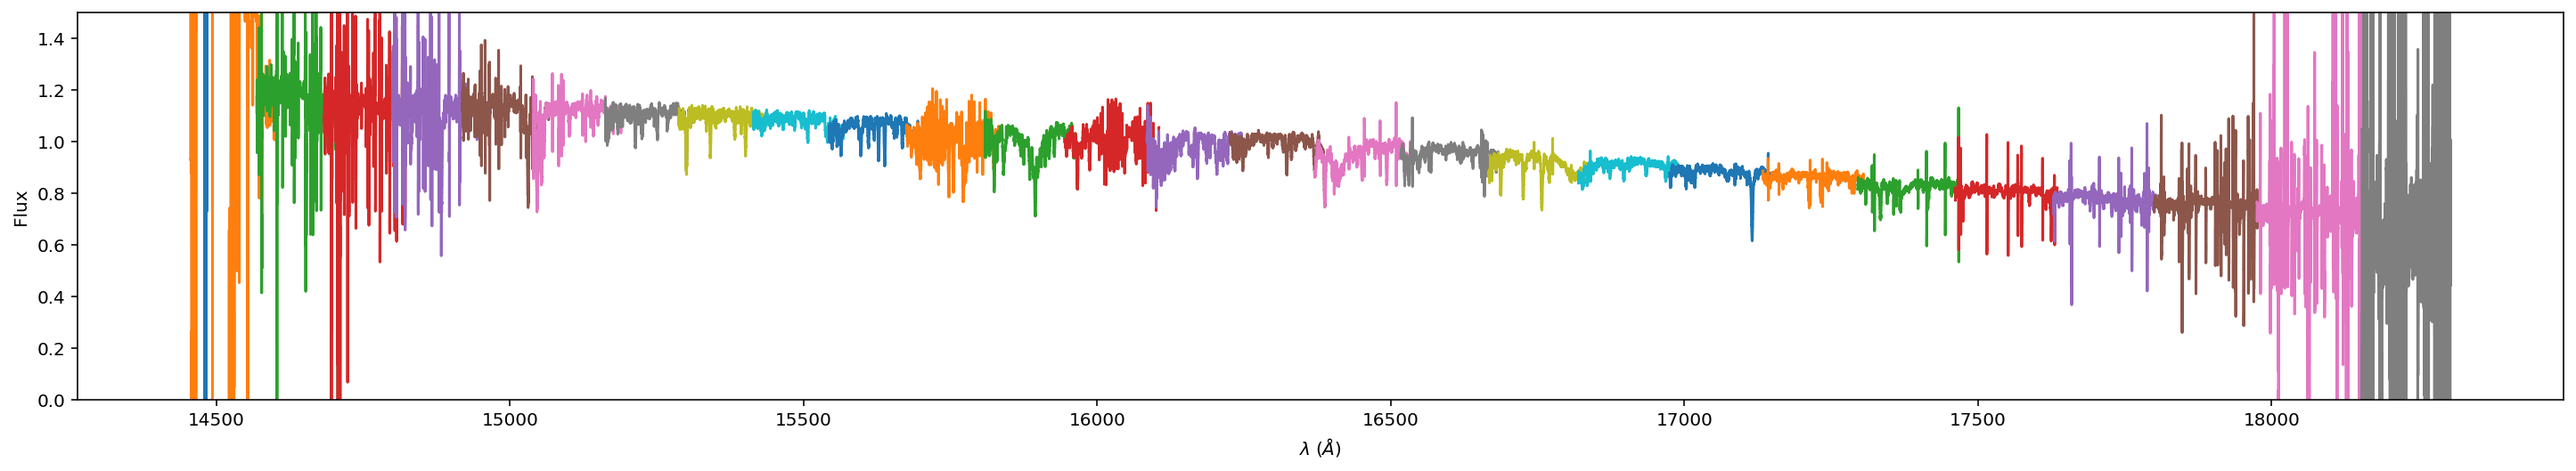

In [5]:
spec_list.remove_nans().trim_edges().normalize(order_index=15).plot(color=None, ylo=0, yhi=1.5);

## Unifying H and K bands into a single `IGRINSSpectrumList`

In [6]:
filename2 = 'SDCK_20201202_0059.spec_a0v.fits'
spec_list2 = IGRINSSpectrumList.read(path+filename2).normalize()

The `extend()` method works **in-place**, overriding the first argument!  We have to copy the `spec_list` if we want to keep it pristine:

In [7]:
import copy

In [8]:
full_H_and_K_spectrum = copy.deepcopy(spec_list)

In [9]:
full_H_and_K_spectrum.extend(spec_list2)

In [10]:
len(spec_list), len(spec_list2), len(full_H_and_K_spectrum)

(28, 26, 54)

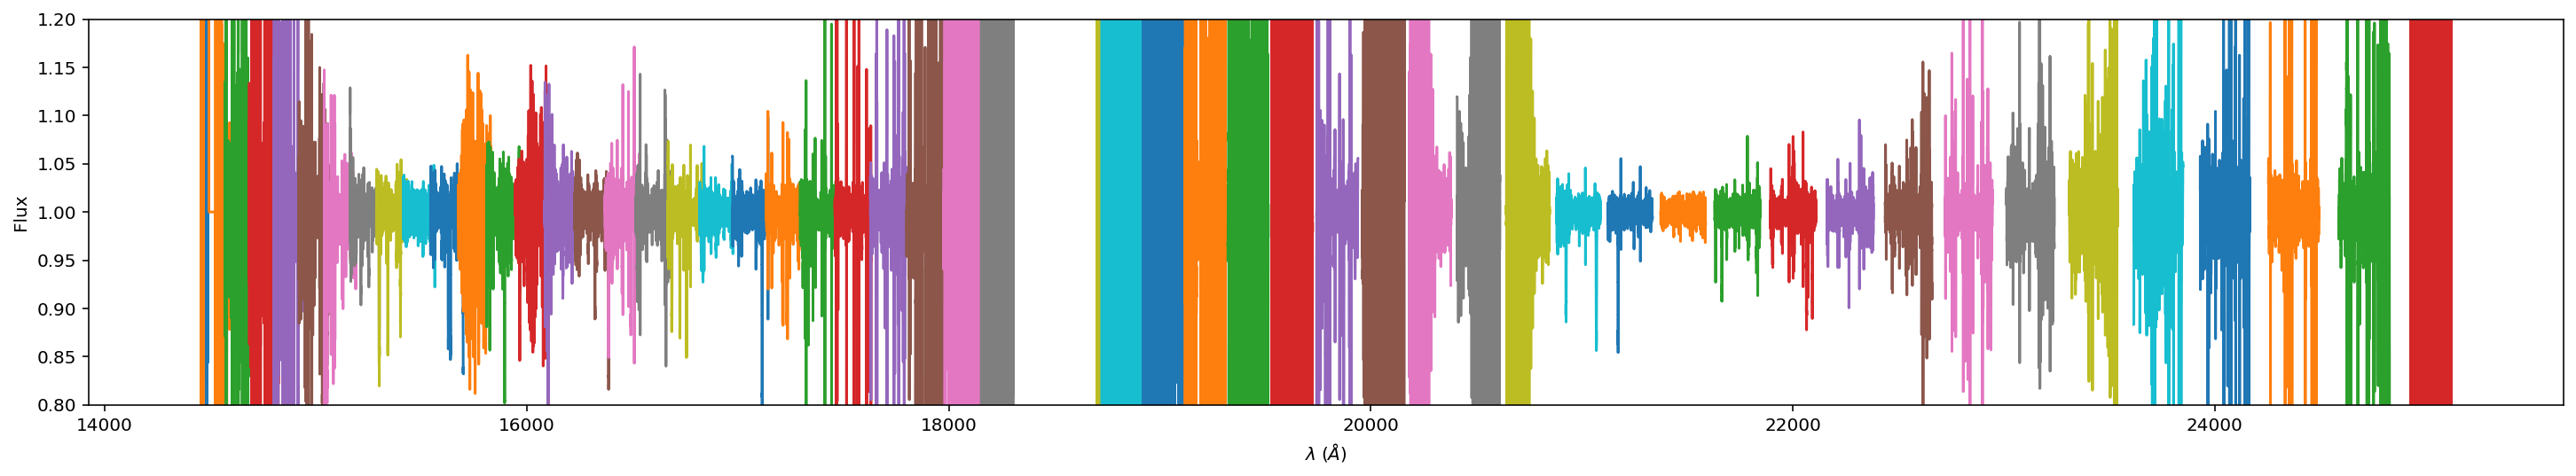

In [11]:
full_H_and_K_spectrum.remove_nans().trim_edges().flatten().plot(color=None, ylo=0.8, yhi=1.2);

## Workarounds

Here we introduce workarounds to three friction points.


### Issue 1: Slicing a `IGRINSSpectrumList`

First, we want to be able to index into the `IGRINSSpectrumList` in the same way you would with a regular old Python List, and still *get back* an `IGRINSSpectrumList`.

In [12]:
type(spec_list)

muler.igrins.IGRINSSpectrumList

In [13]:
sublist = spec_list[4:7]

In [14]:
type(sublist)

list

No! We want this sublist to be an `IGRINSSpectrumList`

In [15]:
sublist_IGRINS = IGRINSSpectrumList(sublist)

In [16]:
type(sublist_IGRINS)

muler.igrins.IGRINSSpectrumList

Yay! This workaround achieved our goal.

### Issue 2: Create an `IGRINSSpectrum` from a bare (`flux`, `wavelength`) array

Often we have already preprocessed a spectrum and have it in-hand as a pair of wavelength coordinates and flux values.  We wish to turn this most elemental format of a spectrum into a `IGRINSSpectrum`.

In [17]:
import astropy.units as u

In [18]:
whole_spectrum = spec_list.remove_nans().trim_edges().normalize().stitch()

In [19]:
len(whole_spectrum.flux.value)

39651

In [20]:
wavelength = whole_spectrum.wavelength.value
flux = whole_spectrum.flux.value

Can we "round-trip" this pair of coordinates and flux values back into an `IGRINSSpectrum`?

In [21]:
roundtrip_spec = IGRINSSpectrum(spectral_axis=wavelength*u.Angstrom, 
                                flux=flux*u.dimensionless_unscaled, )

In [22]:
type(roundtrip_spec)

muler.igrins.IGRINSSpectrum

Some methods will work out-of-the-box:

In [23]:
roundtrip_spec.normalize() # works fine!

<Spectrum1D(flux=<Quantity [-1.03516993, -0.98120918, -0.68644352, ...,  1.03482546,
            0.45246984,  0.55877464]>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [14478.39091936, 14478.47930385, 14478.56768074, ..., 18304.98934269,
   18305.10446116, 18305.21957104] Angstrom>)>

But others do not!

In [24]:
output = whole_spectrum.barycentric_correct() # works fine!

Watch out! This next line will not work!

In [25]:
force = False

if force:
    roundtrip_spec.barycentric_correct() # Oops! Will not work!